In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import PIL
import keras
import os
import numpy as np
import pandas as pd
from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from PIL import Image, ImageOps
import itertools
from numpy import expand_dims
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import cv2

In [3]:
bird_class = pd.read_excel('/content/gdrive/MyDrive/DSCI552_Final/Data/Classes.xlsx')
y = OneHotEncoder().fit_transform(bird_class).toarray()

In [4]:
subdir = []
path = os.getcwd()
path = os.path.join(path,'/content/gdrive/MyDrive/DSCI552_Final/Data/images')

for folder in os.listdir(path):
  fullpath = os.path.join(path, folder)
  if folder.endswith('.DS_Store'): 
      pass
  else:
    subdir.append(fullpath)   

In [5]:
#Split data: 70% train, 15% test, 15% validate
train_path = []
val_path = []
test_path = []
desired_size = 224

for each_folder in subdir:
  data_path_list = []
  for file in os.listdir(each_folder):
    path = os.path.join(each_folder, file)
    newPath = path.replace(os.sep, '/')
    data_path_list.append(newPath)

    image = cv2.imread(newPath)
    # image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    image = cv2.resize(image, (224,224)) 
    cv2.imwrite(newPath,image)
    
  data = pd.DataFrame(data_path_list)
  train, validate, test = np.split(data.sample(frac=1, random_state=25), [int(.7*len(data)), int(.85*len(data))])
  train_path.append(train[0].values.tolist())
  val_path.append(validate[0].values.tolist())
  test_path.append(validate[0].values.tolist())

train_path = list(itertools.chain(*train_path))
val_path = list(itertools.chain(*val_path))
test_path = list(itertools.chain(*test_path))

In [6]:
from google.colab.patches import cv2_imshow
train_path[0]
image = cv2.imread(train_path[0])
image.shape

(224, 224, 3)

In [7]:
bird_class = pd.read_excel('/content/gdrive/MyDrive/DSCI552_Final/Data/Classes.xlsx')
bird_class = bird_class.rename(columns = {"Folder Name ": "Folder"})
bird_class = bird_class.drop(columns = "Class")
y = OneHotEncoder().fit_transform(bird_class).toarray()

In [8]:
final_train_list = []
final_test_list = []
final_val_list = []
def resize_onehot(path):
  final_list = []
  for each_image_path in path:
    for index, row in bird_class.iterrows():
      if row["Folder"] in each_image_path:
        im = cv2.imread(each_image_path)
        final_list.append([im, y[index]])
  return final_list

final_train_list = resize_onehot(train_path)
final_test_list = resize_onehot(test_path)
final_val_list = resize_onehot(val_path)

In [9]:
len(final_train_list)

820

In [10]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for each in final_train_list:
  x_train.append(each[0])
  y_train.append(each[1])
for each in final_test_list:
  x_test.append(each[0])
  y_test.append(each[1])
for each in final_val_list:
  x_val.append(each[0])
  y_val.append(each[1])


In [11]:
len(x_train)

820

In [12]:
#Rotation
import cv2
from google.colab.patches import cv2_imshow
def rotation(each_path):
  image = cv2.imread(each_path)
  height, width = image.shape[:2]
  center = (width/2, height/2)

  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=45, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(rotated_image)
      y_train.append(y[index])
      final_train_list.append([rotated_image, y[index]])

In [13]:
#Translate
def translate(each_path):
  image = cv2.imread(each_path)
  height, width = image.shape[:2]
  tx, ty = width / 4, height / 4
  translation_matrix = np.array([
      [1, 0, tx],
      [0, 1, ty]
  ], dtype=np.float32)
  translated_image = cv2.warpAffine(src=image, M=translation_matrix, dsize=(width, height))

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(translated_image)
      y_train.append(y[index])
      final_train_list.append([translated_image, y[index]])


In [14]:
#Crop
desired_size = 224
def crop(each_path):
  img = cv2.imread(each_path)
  cropped_image = img[50:174, 50:174]
  cropped_image = cv2.resize(cropped_image, (224,224)) 

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(cropped_image)
      y_train.append(y[index])
      final_train_list.append([cropped_image, y[index]])

In [15]:
#Randomly zoom
import random 
def zoom(each_path):
  image = load_img(each_path)
  dataImage = img_to_array(image)
  imageNew = expand_dims(dataImage, 0)

  imageDataGen = ImageDataGenerator(zoom_range=[0.7,1.0])
  iterator = imageDataGen.flow(imageNew, batch_size=1)
  batch = iterator.next()
  image = batch[0].astype('uint8')

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(image)
      y_train.append(y[index])
      final_train_list.append([image, y[index]])

In [16]:
#flip
def flip(each_path):
  img = cv2.imread(each_path)
  vertical_img = cv2.flip(img, 0)
  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(vertical_img)
      y_train.append(y[index])
      final_train_list.append([vertical_img, y[index]])

In [17]:
#Contrast
def contrast(each_path):
  img = cv2.imread(each_path)
  lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  limg = cv2.merge((cl,a,b))
  enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR) 

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(enhanced_img)
      y_train.append(y[index])
      final_train_list.append([enhanced_img, y[index]])

In [18]:
for each_path in train_path:
  k_num = random.randint(1,6)
  aug = (rotation, translate, crop, zoom, flip, contrast)
  aug_list = random.choices(aug, k=6)
  for each_aug in aug_list:
    each_aug(each_path)

In [19]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [20]:
len(x_train)

5740

Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization
4
and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size,
but a batch size of 5 seems reasonable

In [21]:
base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',pooling='avg',classes=20)

In [22]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam
from keras.layers import LSTM


data = np.expand_dims(data, axis=0)

model = keras.Sequential()
model.add(base_model)
for layer in model.layers[:]:
    layer.trainable = False
# model.add(keras.layers.MaxPooling2D())
# model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Dense(20, activation=('softmax')))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.build(input_shape=(224,224,3))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 20)                10260     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                        

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

x_train = tf.stack(x_train)
y_train = tf.stack(y_train)
x_val = tf.stack(x_val)
y_val = tf.stack(y_val)
x_train = tf.keras.applications.vgg16.preprocess_input(x_train)

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [25]:
hist = model.fit(np.array(x_train), np.array(y_train), validation_data=(x_val,y_val), epochs=100, 
                 callbacks = [checkpoint,early, keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)], batch_size = 25)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 3.3255 - accuracy: 0.0645

230/230 [==============================] - 10s 26ms/step - loss: 3.3255 - accuracy: 0.0645 - val_loss: 3.3374 - val_accuracy: 0.0899 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.998999847394012e-05.
Epoch 2/100
229/230 [============================>.] - ETA: 0s - loss: 2.8856 - accuracy: 0.1289

230/230 [==============================] - 5s 22ms/step - loss: 2.8854 - accuracy: 0.1289 - val_loss: 2.9122 - val_accuracy: 0.1629 - lr: 9.9990e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.997000630676428e-05.
Epoch 3/100
228/230 [============================>.] - ETA: 0s - loss: 2.5965 - accuracy: 0.2109

230/230 [==============================] - 5s 22ms/step - loss: 2.5954 - accuracy: 0.2111 - val_loss: 2.6294 - val_accuracy: 0.2022 - lr: 9.9970e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.994002396931107e-05.
Epoch 4/100
229/230 [============================>.] - ETA: 0s - loss: 2.3521 - accuracy: 0.3004

230/230 [==============================] - 5s 22ms/step - loss: 2.3521 - accuracy: 0.3003 - val_loss: 2.4191 - val_accuracy: 0.2809 - lr: 9.9940e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.990006173048161e-05.
Epoch 5/100
229/230 [============================>.] - ETA: 0s - loss: 2.1352 - accuracy: 0.3728

230/230 [==============================] - 5s 22ms/step - loss: 2.1348 - accuracy: 0.3732 - val_loss: 2.2481 - val_accuracy: 0.3202 - lr: 9.9900e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.985013712739302e-05.
Epoch 6/100
228/230 [============================>.] - ETA: 0s - loss: 1.9441 - accuracy: 0.4411

230/230 [==============================] - 5s 22ms/step - loss: 1.9429 - accuracy: 0.4413 - val_loss: 2.1111 - val_accuracy: 0.3764 - lr: 9.9850e-05

Epoch 7: LearningRateScheduler setting learning rate to 9.979026041855706e-05.
Epoch 7/100
229/230 [============================>.] - ETA: 0s - loss: 1.7689 - accuracy: 0.4957

230/230 [==============================] - 5s 22ms/step - loss: 1.7685 - accuracy: 0.4960 - val_loss: 2.0110 - val_accuracy: 0.3876 - lr: 9.9790e-05

Epoch 8: LearningRateScheduler setting learning rate to 9.972045640012098e-05.
Epoch 8/100
229/230 [============================>.] - ETA: 0s - loss: 1.6340 - accuracy: 0.5382

230/230 [==============================] - 5s 22ms/step - loss: 1.6335 - accuracy: 0.5385 - val_loss: 1.9271 - val_accuracy: 0.4213 - lr: 9.9720e-05

Epoch 9: LearningRateScheduler setting learning rate to 9.964074258818005e-05.
Epoch 9/100
229/230 [============================>.] - ETA: 0s - loss: 1.4998 - accuracy: 0.5810

230/230 [==============================] - 5s 22ms/step - loss: 1.4998 - accuracy: 0.5810 - val_loss: 1.8442 - val_accuracy: 0.4551 - lr: 9.9641e-05

Epoch 10: LearningRateScheduler setting learning rate to 9.955114376124448e-05.
Epoch 10/100
229/230 [============================>.] - ETA: 0s - loss: 1.3845 - accuracy: 0.6141

230/230 [==============================] - 5s 22ms/step - loss: 1.3835 - accuracy: 0.6146 - val_loss: 1.7770 - val_accuracy: 0.4551 - lr: 9.9551e-05

Epoch 11: LearningRateScheduler setting learning rate to 9.945169195661194e-05.
Epoch 11/100
228/230 [============================>.] - ETA: 0s - loss: 1.2708 - accuracy: 0.6496

230/230 [==============================] - 5s 23ms/step - loss: 1.2721 - accuracy: 0.6491 - val_loss: 1.7381 - val_accuracy: 0.4719 - lr: 9.9452e-05

Epoch 12: LearningRateScheduler setting learning rate to 9.934241193081636e-05.
Epoch 12/100
229/230 [============================>.] - ETA: 0s - loss: 1.1918 - accuracy: 0.6669

230/230 [==============================] - 5s 22ms/step - loss: 1.1926 - accuracy: 0.6666 - val_loss: 1.7035 - val_accuracy: 0.4944 - lr: 9.9342e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.922334296497487e-05.
Epoch 13/100
229/230 [============================>.] - ETA: 0s - loss: 1.1176 - accuracy: 0.6828

230/230 [==============================] - 5s 22ms/step - loss: 1.1167 - accuracy: 0.6833 - val_loss: 1.6770 - val_accuracy: 0.5000 - lr: 9.9223e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.909451705800132e-05.
Epoch 14/100
229/230 [============================>.] - ETA: 0s - loss: 1.0415 - accuracy: 0.7039

230/230 [==============================] - 5s 22ms/step - loss: 1.0417 - accuracy: 0.7037 - val_loss: 1.6540 - val_accuracy: 0.5056 - lr: 9.9095e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.895598072759898e-05.
Epoch 15/100
229/230 [============================>.] - ETA: 0s - loss: 0.9930 - accuracy: 0.7163

230/230 [==============================] - 5s 22ms/step - loss: 0.9926 - accuracy: 0.7160 - val_loss: 1.6167 - val_accuracy: 0.5056 - lr: 9.8956e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.880776594277179e-05.
Epoch 16/100
228/230 [============================>.] - ETA: 0s - loss: 0.9381 - accuracy: 0.7318

230/230 [==============================] - 5s 22ms/step - loss: 0.9381 - accuracy: 0.7319 - val_loss: 1.5908 - val_accuracy: 0.5112 - lr: 9.8808e-05

Epoch 17: LearningRateScheduler setting learning rate to 9.864992645276061e-05.
Epoch 17/100
229/230 [============================>.] - ETA: 0s - loss: 0.8847 - accuracy: 0.7445

230/230 [==============================] - 5s 22ms/step - loss: 0.8847 - accuracy: 0.7443 - val_loss: 1.5694 - val_accuracy: 0.5112 - lr: 9.8650e-05

Epoch 18: LearningRateScheduler setting learning rate to 9.84825087217336e-05.
Epoch 18/100
228/230 [============================>.] - ETA: 0s - loss: 0.8394 - accuracy: 0.7533

230/230 [==============================] - 5s 22ms/step - loss: 0.8380 - accuracy: 0.7538 - val_loss: 1.5656 - val_accuracy: 0.5337 - lr: 9.8483e-05

Epoch 19: LearningRateScheduler setting learning rate to 9.830555919530664e-05.
Epoch 19/100
229/230 [============================>.] - ETA: 0s - loss: 0.7936 - accuracy: 0.7696

230/230 [==============================] - 5s 22ms/step - loss: 0.7935 - accuracy: 0.7695 - val_loss: 1.5565 - val_accuracy: 0.5393 - lr: 9.8306e-05

Epoch 20: LearningRateScheduler setting learning rate to 9.81191315627121e-05.
Epoch 20/100
229/230 [============================>.] - ETA: 0s - loss: 0.7773 - accuracy: 0.7762

230/230 [==============================] - 5s 22ms/step - loss: 0.7771 - accuracy: 0.7763 - val_loss: 1.5492 - val_accuracy: 0.5337 - lr: 9.8119e-05

Epoch 21: LearningRateScheduler setting learning rate to 9.792328675318427e-05.
Epoch 21/100
228/230 [============================>.] - ETA: 0s - loss: 0.7399 - accuracy: 0.7886

230/230 [==============================] - 5s 22ms/step - loss: 0.7411 - accuracy: 0.7878 - val_loss: 1.5076 - val_accuracy: 0.5506 - lr: 9.7923e-05

Epoch 22: LearningRateScheduler setting learning rate to 9.771807841092672e-05.
Epoch 22/100
229/230 [============================>.] - ETA: 0s - loss: 0.7126 - accuracy: 0.7949

230/230 [==============================] - 5s 22ms/step - loss: 0.7123 - accuracy: 0.7949 - val_loss: 1.5266 - val_accuracy: 0.5562 - lr: 9.7718e-05

Epoch 23: LearningRateScheduler setting learning rate to 9.750356741871807e-05.
Epoch 23/100
229/230 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.7946

230/230 [==============================] - 5s 22ms/step - loss: 0.6835 - accuracy: 0.7948 - val_loss: 1.5028 - val_accuracy: 0.5562 - lr: 9.7504e-05

Epoch 24: LearningRateScheduler setting learning rate to 9.727982189430099e-05.
Epoch 24/100
229/230 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.8070

230/230 [==============================] - 5s 22ms/step - loss: 0.6538 - accuracy: 0.8071 - val_loss: 1.5042 - val_accuracy: 0.5674 - lr: 9.7280e-05

Epoch 25: LearningRateScheduler setting learning rate to 9.704690992823636e-05.
Epoch 25/100
229/230 [============================>.] - ETA: 0s - loss: 0.6250 - accuracy: 0.8131

230/230 [==============================] - 5s 22ms/step - loss: 0.6247 - accuracy: 0.8129 - val_loss: 1.4782 - val_accuracy: 0.5730 - lr: 9.7047e-05

Epoch 26: LearningRateScheduler setting learning rate to 9.680489958391672e-05.
Epoch 26/100
228/230 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.8309

230/230 [==============================] - 5s 22ms/step - loss: 0.5995 - accuracy: 0.8303 - val_loss: 1.4814 - val_accuracy: 0.5674 - lr: 9.6805e-05

Epoch 27: LearningRateScheduler setting learning rate to 9.655385889757983e-05.
Epoch 27/100
229/230 [============================>.] - ETA: 0s - loss: 0.5985 - accuracy: 0.8243

230/230 [==============================] - 5s 22ms/step - loss: 0.5982 - accuracy: 0.8240 - val_loss: 1.4719 - val_accuracy: 0.5674 - lr: 9.6554e-05

Epoch 28: LearningRateScheduler setting learning rate to 9.629386313468771e-05.
Epoch 28/100
229/230 [============================>.] - ETA: 0s - loss: 0.5762 - accuracy: 0.8297

230/230 [==============================] - 5s 22ms/step - loss: 0.5764 - accuracy: 0.8293 - val_loss: 1.4870 - val_accuracy: 0.5618 - lr: 9.6294e-05

Epoch 29: LearningRateScheduler setting learning rate to 9.602499478632206e-05.
Epoch 29/100
229/230 [============================>.] - ETA: 0s - loss: 0.5542 - accuracy: 0.8383

230/230 [==============================] - 5s 22ms/step - loss: 0.5552 - accuracy: 0.8380 - val_loss: 1.4441 - val_accuracy: 0.5674 - lr: 9.6025e-05

Epoch 30: LearningRateScheduler setting learning rate to 9.574732905574518e-05.
Epoch 30/100
229/230 [============================>.] - ETA: 0s - loss: 0.5418 - accuracy: 0.8372

230/230 [==============================] - 5s 22ms/step - loss: 0.5410 - accuracy: 0.8375 - val_loss: 1.4587 - val_accuracy: 0.5618 - lr: 9.5747e-05

Epoch 31: LearningRateScheduler setting learning rate to 9.54609483704231e-05.
Epoch 31/100
228/230 [============================>.] - ETA: 0s - loss: 0.5228 - accuracy: 0.8404

230/230 [==============================] - 5s 22ms/step - loss: 0.5229 - accuracy: 0.8404 - val_loss: 1.4591 - val_accuracy: 0.5618 - lr: 9.5461e-05

Epoch 32: LearningRateScheduler setting learning rate to 9.516593512495273e-05.
Epoch 32/100
229/230 [============================>.] - ETA: 0s - loss: 0.5147 - accuracy: 0.8473

230/230 [==============================] - 5s 22ms/step - loss: 0.5148 - accuracy: 0.8474 - val_loss: 1.4277 - val_accuracy: 0.5899 - lr: 9.5166e-05

Epoch 33: LearningRateScheduler setting learning rate to 9.486237893382716e-05.
Epoch 33/100
228/230 [============================>.] - ETA: 0s - loss: 0.4950 - accuracy: 0.8525

230/230 [==============================] - 5s 22ms/step - loss: 0.4953 - accuracy: 0.8524 - val_loss: 1.4306 - val_accuracy: 0.5955 - lr: 9.4862e-05

Epoch 34: LearningRateScheduler setting learning rate to 9.455036212378557e-05.
Epoch 34/100
229/230 [============================>.] - ETA: 0s - loss: 0.4845 - accuracy: 0.8564

230/230 [==============================] - 5s 22ms/step - loss: 0.4851 - accuracy: 0.8563 - val_loss: 1.4205 - val_accuracy: 0.5899 - lr: 9.4550e-05

Epoch 35: LearningRateScheduler setting learning rate to 9.422998149135443e-05.
Epoch 35/100
229/230 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.8622

230/230 [==============================] - 5s 22ms/step - loss: 0.4696 - accuracy: 0.8617 - val_loss: 1.4328 - val_accuracy: 0.6011 - lr: 9.4230e-05

Epoch 36: LearningRateScheduler setting learning rate to 9.390132654389606e-05.
Epoch 36/100
230/230 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8584

230/230 [==============================] - 5s 22ms/step - loss: 0.4680 - accuracy: 0.8584 - val_loss: 1.4214 - val_accuracy: 0.6236 - lr: 9.3901e-05

Epoch 37: LearningRateScheduler setting learning rate to 9.35644940029564e-05.
Epoch 37/100
229/230 [============================>.] - ETA: 0s - loss: 0.4427 - accuracy: 0.8678

230/230 [==============================] - 5s 22ms/step - loss: 0.4428 - accuracy: 0.8679 - val_loss: 1.4164 - val_accuracy: 0.6180 - lr: 9.3564e-05

Epoch 38: LearningRateScheduler setting learning rate to 9.321958055153534e-05.
Epoch 38/100
229/230 [============================>.] - ETA: 0s - loss: 0.4363 - accuracy: 0.8686

230/230 [==============================] - 5s 22ms/step - loss: 0.4363 - accuracy: 0.8688 - val_loss: 1.4082 - val_accuracy: 0.6180 - lr: 9.3220e-05

Epoch 39: LearningRateScheduler setting learning rate to 9.286669008251971e-05.
Epoch 39/100
229/230 [============================>.] - ETA: 0s - loss: 0.4393 - accuracy: 0.8700

230/230 [==============================] - 5s 22ms/step - loss: 0.4393 - accuracy: 0.8702 - val_loss: 1.4226 - val_accuracy: 0.6180 - lr: 9.2867e-05

Epoch 40: LearningRateScheduler setting learning rate to 9.25059191997089e-05.
Epoch 40/100
230/230 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8789

230/230 [==============================] - 5s 23ms/step - loss: 0.4149 - accuracy: 0.8789 - val_loss: 1.4054 - val_accuracy: 0.6180 - lr: 9.2506e-05

Epoch 41: LearningRateScheduler setting learning rate to 9.213737171538456e-05.
Epoch 41/100
229/230 [============================>.] - ETA: 0s - loss: 0.4188 - accuracy: 0.8746

230/230 [==============================] - 5s 22ms/step - loss: 0.4198 - accuracy: 0.8740 - val_loss: 1.4202 - val_accuracy: 0.6124 - lr: 9.2137e-05

Epoch 42: LearningRateScheduler setting learning rate to 9.176115140047293e-05.
Epoch 42/100
229/230 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.8851

230/230 [==============================] - 5s 22ms/step - loss: 0.3961 - accuracy: 0.8852 - val_loss: 1.4127 - val_accuracy: 0.6292 - lr: 9.1761e-05

Epoch 43: LearningRateScheduler setting learning rate to 9.13773692300919e-05.
Epoch 43/100
228/230 [============================>.] - ETA: 0s - loss: 0.3963 - accuracy: 0.8775

230/230 [==============================] - 5s 22ms/step - loss: 0.3967 - accuracy: 0.8770 - val_loss: 1.4215 - val_accuracy: 0.6348 - lr: 9.1377e-05

Epoch 44: LearningRateScheduler setting learning rate to 9.098612889035443e-05.
Epoch 44/100
229/230 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8880

230/230 [==============================] - 5s 22ms/step - loss: 0.3801 - accuracy: 0.8882 - val_loss: 1.4060 - val_accuracy: 0.6404 - lr: 9.0986e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.058754127016436e-05.
Epoch 45/100
229/230 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8837

230/230 [==============================] - 5s 22ms/step - loss: 0.3878 - accuracy: 0.8838 - val_loss: 1.3870 - val_accuracy: 0.6348 - lr: 9.0588e-05

Epoch 46: LearningRateScheduler setting learning rate to 9.018172445763116e-05.
Epoch 46/100
229/230 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8821

230/230 [==============================] - 5s 22ms/step - loss: 0.3824 - accuracy: 0.8821 - val_loss: 1.4331 - val_accuracy: 0.6348 - lr: 9.0182e-05

Epoch 47: LearningRateScheduler setting learning rate to 8.976878925120389e-05.
Epoch 47/100
229/230 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.8833

230/230 [==============================] - 5s 22ms/step - loss: 0.3782 - accuracy: 0.8833 - val_loss: 1.4313 - val_accuracy: 0.6404 - lr: 8.9769e-05

Epoch 48: LearningRateScheduler setting learning rate to 8.934884640521953e-05.
Epoch 48/100
228/230 [============================>.] - ETA: 0s - loss: 0.3638 - accuracy: 0.8872

230/230 [==============================] - 5s 22ms/step - loss: 0.3641 - accuracy: 0.8871 - val_loss: 1.4248 - val_accuracy: 0.6404 - lr: 8.9349e-05

Epoch 49: LearningRateScheduler setting learning rate to 8.892202111232468e-05.
Epoch 49/100
229/230 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.8938

230/230 [==============================] - 5s 22ms/step - loss: 0.3471 - accuracy: 0.8937 - val_loss: 1.4286 - val_accuracy: 0.6461 - lr: 8.8922e-05

Epoch 50: LearningRateScheduler setting learning rate to 8.848843127485384e-05.
Epoch 50/100
229/230 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8980

230/230 [==============================] - 5s 22ms/step - loss: 0.3378 - accuracy: 0.8983 - val_loss: 1.4332 - val_accuracy: 0.6404 - lr: 8.8488e-05

Epoch 51: LearningRateScheduler setting learning rate to 8.804818750845631e-05.
Epoch 51/100
228/230 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.8977

230/230 [==============================] - 5s 23ms/step - loss: 0.3475 - accuracy: 0.8976 - val_loss: 1.4180 - val_accuracy: 0.6404 - lr: 8.8048e-05

Epoch 52: LearningRateScheduler setting learning rate to 8.760142210187523e-05.
Epoch 52/100
229/230 [============================>.] - ETA: 0s - loss: 0.3328 - accuracy: 0.9032

230/230 [==============================] - 5s 22ms/step - loss: 0.3324 - accuracy: 0.9033 - val_loss: 1.4070 - val_accuracy: 0.6461 - lr: 8.7601e-05

Epoch 53: LearningRateScheduler setting learning rate to 8.714825281457529e-05.
Epoch 53/100
229/230 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.8959

230/230 [==============================] - 5s 22ms/step - loss: 0.3272 - accuracy: 0.8956 - val_loss: 1.4011 - val_accuracy: 0.6461 - lr: 8.7148e-05

Epoch 54: LearningRateScheduler setting learning rate to 8.668880459676405e-05.
Epoch 54/100
229/230 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.9069

230/230 [==============================] - 5s 22ms/step - loss: 0.3163 - accuracy: 0.9070 - val_loss: 1.3945 - val_accuracy: 0.6517 - lr: 8.6689e-05

Epoch 55: LearningRateScheduler setting learning rate to 8.622320234893741e-05.
Epoch 55/100
229/230 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.8992

230/230 [==============================] - 5s 22ms/step - loss: 0.3248 - accuracy: 0.8993 - val_loss: 1.3958 - val_accuracy: 0.6517 - lr: 8.6223e-05

Epoch 56: LearningRateScheduler setting learning rate to 8.575157092190437e-05.
Epoch 56/100
230/230 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.9044

230/230 [==============================] - 5s 22ms/step - loss: 0.3171 - accuracy: 0.9044 - val_loss: 1.4091 - val_accuracy: 0.6573 - lr: 8.5752e-05

Epoch 57: LearningRateScheduler setting learning rate to 8.527403511681172e-05.
Epoch 57/100
229/230 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.9006

230/230 [==============================] - 5s 22ms/step - loss: 0.3179 - accuracy: 0.9007 - val_loss: 1.3894 - val_accuracy: 0.6517 - lr: 8.5274e-05

Epoch 58: LearningRateScheduler setting learning rate to 8.479072691988841e-05.
Epoch 58/100
228/230 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.9054

230/230 [==============================] - 5s 22ms/step - loss: 0.3058 - accuracy: 0.9056 - val_loss: 1.4000 - val_accuracy: 0.6573 - lr: 8.4791e-05

Epoch 59: LearningRateScheduler setting learning rate to 8.430177826487338e-05.
Epoch 59/100
229/230 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.9062

230/230 [==============================] - 5s 22ms/step - loss: 0.3089 - accuracy: 0.9064 - val_loss: 1.4323 - val_accuracy: 0.6517 - lr: 8.4302e-05

Epoch 60: LearningRateScheduler setting learning rate to 8.380731379976033e-05.
Epoch 60/100
229/230 [============================>.] - ETA: 0s - loss: 0.3012 - accuracy: 0.9102

230/230 [==============================] - 5s 22ms/step - loss: 0.3017 - accuracy: 0.9099 - val_loss: 1.4132 - val_accuracy: 0.6517 - lr: 8.3807e-05

Epoch 61: LearningRateScheduler setting learning rate to 8.330747258810559e-05.
Epoch 61/100
228/230 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.9132

230/230 [==============================] - 5s 22ms/step - loss: 0.2912 - accuracy: 0.9136 - val_loss: 1.4289 - val_accuracy: 0.6517 - lr: 8.3307e-05

Epoch 62: LearningRateScheduler setting learning rate to 8.280237917449067e-05.
Epoch 62/100
229/230 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.9163

230/230 [==============================] - 5s 22ms/step - loss: 0.2890 - accuracy: 0.9152 - val_loss: 1.4222 - val_accuracy: 0.6461 - lr: 8.2802e-05

Epoch 63: LearningRateScheduler setting learning rate to 8.229216528511076e-05.
Epoch 63/100
229/230 [============================>.] - ETA: 0s - loss: 0.2868 - accuracy: 0.9113

230/230 [==============================] - 5s 22ms/step - loss: 0.2867 - accuracy: 0.9113 - val_loss: 1.4248 - val_accuracy: 0.6461 - lr: 8.2292e-05

Epoch 64: LearningRateScheduler setting learning rate to 8.177696982420656e-05.
Epoch 64/100
229/230 [============================>.] - ETA: 0s - loss: 0.2801 - accuracy: 0.9125

230/230 [==============================] - 5s 22ms/step - loss: 0.2808 - accuracy: 0.9118 - val_loss: 1.4209 - val_accuracy: 0.6517 - lr: 8.1777e-05

Epoch 65: LearningRateScheduler setting learning rate to 8.125692441112277e-05.
Epoch 65/100
229/230 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.9155

230/230 [==============================] - 5s 22ms/step - loss: 0.2793 - accuracy: 0.9155 - val_loss: 1.4274 - val_accuracy: 0.6461 - lr: 8.1257e-05

Epoch 66: LearningRateScheduler setting learning rate to 8.073216784186569e-05.
Epoch 66/100
228/230 [============================>.] - ETA: 0s - loss: 0.2783 - accuracy: 0.9184

230/230 [==============================] - 5s 22ms/step - loss: 0.2781 - accuracy: 0.9186 - val_loss: 1.4353 - val_accuracy: 0.6517 - lr: 8.0732e-05

Epoch 67: LearningRateScheduler setting learning rate to 8.020283162903605e-05.
Epoch 67/100
229/230 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.9219

230/230 [==============================] - 5s 22ms/step - loss: 0.2675 - accuracy: 0.9220 - val_loss: 1.4488 - val_accuracy: 0.6404 - lr: 8.0203e-05

Epoch 68: LearningRateScheduler setting learning rate to 7.966904723297965e-05.
Epoch 68/100
228/230 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.9239

230/230 [==============================] - 5s 22ms/step - loss: 0.2696 - accuracy: 0.9237 - val_loss: 1.4520 - val_accuracy: 0.6404 - lr: 7.9669e-05

Epoch 69: LearningRateScheduler setting learning rate to 7.91309532886286e-05.
Epoch 69/100
229/230 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.9202

230/230 [==============================] - 5s 22ms/step - loss: 0.2669 - accuracy: 0.9202 - val_loss: 1.4561 - val_accuracy: 0.6461 - lr: 7.9131e-05

Epoch 70: LearningRateScheduler setting learning rate to 7.858868837584103e-05.
Epoch 70/100
229/230 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9205

230/230 [==============================] - 5s 22ms/step - loss: 0.2678 - accuracy: 0.9200 - val_loss: 1.4439 - val_accuracy: 0.6404 - lr: 7.8589e-05

Epoch 71: LearningRateScheduler setting learning rate to 7.804239101942847e-05.
Epoch 71/100
229/230 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9169

230/230 [==============================] - 5s 22ms/step - loss: 0.2629 - accuracy: 0.9169 - val_loss: 1.4373 - val_accuracy: 0.6461 - lr: 7.8042e-05

Epoch 72: LearningRateScheduler setting learning rate to 7.749219968918314e-05.
Epoch 72/100
229/230 [============================>.] - ETA: 0s - loss: 0.2534 - accuracy: 0.9224

230/230 [==============================] - 5s 22ms/step - loss: 0.2538 - accuracy: 0.9223 - val_loss: 1.4518 - val_accuracy: 0.6348 - lr: 7.7492e-05

Epoch 73: LearningRateScheduler setting learning rate to 7.693824557596011e-05.
Epoch 73/100
230/230 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9174

230/230 [==============================] - 5s 23ms/step - loss: 0.2645 - accuracy: 0.9174 - val_loss: 1.4490 - val_accuracy: 0.6348 - lr: 7.6938e-05

Epoch 74: LearningRateScheduler setting learning rate to 7.638066704174642e-05.
Epoch 74/100
229/230 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.9223

230/230 [==============================] - 5s 22ms/step - loss: 0.2543 - accuracy: 0.9221 - val_loss: 1.4524 - val_accuracy: 0.6348 - lr: 7.6381e-05

Epoch 75: LearningRateScheduler setting learning rate to 7.581960239359087e-05.
Epoch 75/100
229/230 [============================>.] - ETA: 0s - loss: 0.2570 - accuracy: 0.9212

230/230 [==============================] - 5s 22ms/step - loss: 0.2575 - accuracy: 0.9209 - val_loss: 1.4604 - val_accuracy: 0.6348 - lr: 7.5820e-05

Epoch 76: LearningRateScheduler setting learning rate to 7.52551898836313e-05.
Epoch 76/100
228/230 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.9225

230/230 [==============================] - 5s 22ms/step - loss: 0.2549 - accuracy: 0.9225 - val_loss: 1.4847 - val_accuracy: 0.6461 - lr: 7.5255e-05

Epoch 77: LearningRateScheduler setting learning rate to 7.468756770912178e-05.
Epoch 77/100
229/230 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.9216

230/230 [==============================] - 5s 22ms/step - loss: 0.2561 - accuracy: 0.9213 - val_loss: 1.4658 - val_accuracy: 0.6404 - lr: 7.4688e-05

Epoch 78: LearningRateScheduler setting learning rate to 7.411686679209903e-05.
Epoch 78/100
229/230 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9265

230/230 [==============================] - 5s 22ms/step - loss: 0.2477 - accuracy: 0.9261 - val_loss: 1.4599 - val_accuracy: 0.6404 - lr: 7.4117e-05

Epoch 79: LearningRateScheduler setting learning rate to 7.35432324419251e-05.
Epoch 79/100
229/230 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9291

230/230 [==============================] - 5s 22ms/step - loss: 0.2351 - accuracy: 0.9291 - val_loss: 1.4517 - val_accuracy: 0.6461 - lr: 7.3543e-05

Epoch 80: LearningRateScheduler setting learning rate to 7.296679547243763e-05.
Epoch 80/100
229/230 [============================>.] - ETA: 0s - loss: 0.2475 - accuracy: 0.9203

230/230 [==============================] - 5s 22ms/step - loss: 0.2476 - accuracy: 0.9204 - val_loss: 1.4462 - val_accuracy: 0.6404 - lr: 7.2967e-05

Epoch 81: LearningRateScheduler setting learning rate to 7.238769386377599e-05.
Epoch 81/100
229/230 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9280

230/230 [==============================] - 5s 22ms/step - loss: 0.2372 - accuracy: 0.9279 - val_loss: 1.4504 - val_accuracy: 0.6404 - lr: 7.2388e-05

Epoch 82: LearningRateScheduler setting learning rate to 7.180606554133094e-05.
Epoch 82/100
229/230 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9242

230/230 [==============================] - 5s 22ms/step - loss: 0.2442 - accuracy: 0.9242 - val_loss: 1.4809 - val_accuracy: 0.6404 - lr: 7.1806e-05

Epoch 83: LearningRateScheduler setting learning rate to 7.12220483757718e-05.
Epoch 83/100
229/230 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.9268

230/230 [==============================] - 5s 22ms/step - loss: 0.2309 - accuracy: 0.9270 - val_loss: 1.4464 - val_accuracy: 0.6404 - lr: 7.1222e-05

Epoch 84: LearningRateScheduler setting learning rate to 7.06357729670093e-05.
Epoch 84/100
229/230 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9329

230/230 [==============================] - 5s 22ms/step - loss: 0.2218 - accuracy: 0.9329 - val_loss: 1.4727 - val_accuracy: 0.6404 - lr: 7.0636e-05

Epoch 85: LearningRateScheduler setting learning rate to 7.004737707849804e-05.
Epoch 85/100
229/230 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9305

230/230 [==============================] - 5s 22ms/step - loss: 0.2245 - accuracy: 0.9307 - val_loss: 1.4856 - val_accuracy: 0.6404 - lr: 7.0047e-05

Epoch 86: LearningRateScheduler setting learning rate to 6.945699120441846e-05.
Epoch 86/100
228/230 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9337

230/230 [==============================] - 5s 22ms/step - loss: 0.2222 - accuracy: 0.9340 - val_loss: 1.4662 - val_accuracy: 0.6348 - lr: 6.9457e-05

Epoch 87: LearningRateScheduler setting learning rate to 6.886475300111635e-05.
Epoch 87/100
229/230 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9303

230/230 [==============================] - 5s 22ms/step - loss: 0.2242 - accuracy: 0.9303 - val_loss: 1.4652 - val_accuracy: 0.6348 - lr: 6.8865e-05

Epoch 88: LearningRateScheduler setting learning rate to 6.827080007034984e-05.
Epoch 88/100
229/230 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9322

230/230 [==============================] - 5s 22ms/step - loss: 0.2214 - accuracy: 0.9319 - val_loss: 1.4685 - val_accuracy: 0.6404 - lr: 6.8271e-05

Epoch 89: LearningRateScheduler setting learning rate to 6.767525553434103e-05.
Epoch 89/100
229/230 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9312

230/230 [==============================] - 5s 22ms/step - loss: 0.2193 - accuracy: 0.9314 - val_loss: 1.4795 - val_accuracy: 0.6348 - lr: 6.7675e-05

Epoch 90: LearningRateScheduler setting learning rate to 6.707825689004333e-05.
Epoch 90/100
229/230 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9347

230/230 [==============================] - 5s 22ms/step - loss: 0.2231 - accuracy: 0.9345 - val_loss: 1.5010 - val_accuracy: 0.6348 - lr: 6.7078e-05

Epoch 91: LearningRateScheduler setting learning rate to 6.647993436884376e-05.
Epoch 91/100
228/230 [============================>.] - ETA: 0s - loss: 0.2176 - accuracy: 0.9353

230/230 [==============================] - 5s 22ms/step - loss: 0.2180 - accuracy: 0.9352 - val_loss: 1.4816 - val_accuracy: 0.6292 - lr: 6.6480e-05

Epoch 92: LearningRateScheduler setting learning rate to 6.588042536085007e-05.
Epoch 92/100
229/230 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9364

230/230 [==============================] - 5s 22ms/step - loss: 0.2080 - accuracy: 0.9364 - val_loss: 1.4840 - val_accuracy: 0.6292 - lr: 6.5880e-05

Epoch 93: LearningRateScheduler setting learning rate to 6.527985278245694e-05.
Epoch 93/100
229/230 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9336

230/230 [==============================] - 5s 22ms/step - loss: 0.2156 - accuracy: 0.9338 - val_loss: 1.4812 - val_accuracy: 0.6292 - lr: 6.5280e-05

Epoch 94: LearningRateScheduler setting learning rate to 6.46783467102602e-05.
Epoch 94/100
229/230 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9352

230/230 [==============================] - 5s 22ms/step - loss: 0.2124 - accuracy: 0.9348 - val_loss: 1.5003 - val_accuracy: 0.6461 - lr: 6.4678e-05

Epoch 95: LearningRateScheduler setting learning rate to 6.407602996110903e-05.
Epoch 95/100
229/230 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9369

230/230 [==============================] - 5s 22ms/step - loss: 0.2061 - accuracy: 0.9371 - val_loss: 1.5096 - val_accuracy: 0.6292 - lr: 6.4076e-05

Epoch 96: LearningRateScheduler setting learning rate to 6.347303971816121e-05.
Epoch 96/100
229/230 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9354

230/230 [==============================] - 5s 22ms/step - loss: 0.2119 - accuracy: 0.9355 - val_loss: 1.5223 - val_accuracy: 0.6292 - lr: 6.3473e-05

Epoch 97: LearningRateScheduler setting learning rate to 6.286949148990521e-05.
Epoch 97/100
229/230 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9307

230/230 [==============================] - 5s 22ms/step - loss: 0.2122 - accuracy: 0.9307 - val_loss: 1.5209 - val_accuracy: 0.6404 - lr: 6.2869e-05

Epoch 98: LearningRateScheduler setting learning rate to 6.226551515118765e-05.
Epoch 98/100
228/230 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9332

230/230 [==============================] - 5s 22ms/step - loss: 0.2140 - accuracy: 0.9331 - val_loss: 1.5249 - val_accuracy: 0.6461 - lr: 6.2266e-05

Epoch 99: LearningRateScheduler setting learning rate to 6.166123332006417e-05.
Epoch 99/100
229/230 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9369

230/230 [==============================] - 5s 22ms/step - loss: 0.2087 - accuracy: 0.9371 - val_loss: 1.5127 - val_accuracy: 0.6292 - lr: 6.1661e-05

Epoch 100: LearningRateScheduler setting learning rate to 6.105676856602401e-05.
Epoch 100/100
229/230 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9383

230/230 [==============================] - 5s 22ms/step - loss: 0.2060 - accuracy: 0.9380 - val_loss: 1.4893 - val_accuracy: 0.6292 - lr: 6.1057e-05


6/6 [==============================] - 1s 109ms/step - loss: 0.6779 - accuracy: 0.8090
Train: 0.994, Test: 0.809


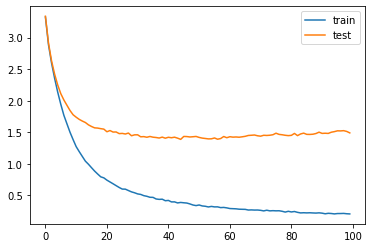

In [26]:
x_test = tf.stack(x_test)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test)
y_test = tf.stack(y_test)

# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=1)
_, test_acc = model.evaluate(x_test, y_test, verbose=1)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred=model.predict(x_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)

print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))


6/6 [==============================] - 0s 23ms/step
[[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 7 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 2 0 0 1 0 0 0 1]
 [0 0 1 0 0 7 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 7 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 8 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 5 2 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 1 1 6 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9]]
              precision    recall  f1-score   support

           0       1.00      0.8

In [28]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)

model = keras.Sequential()
model.add(base_model)
for layer in model.layers[:]:
    layer.trainable = False

# model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Dense(20, activation=('softmax')))


opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.build(input_shape=(224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                20020     
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                      

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

checkpoint = ModelCheckpoint("best.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')


In [30]:
hist = model.fit(np.array(x_train), np.array(y_train), validation_data=(x_val,y_val), epochs=100, 
                 callbacks = [checkpoint,early, keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)], batch_size = 25)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 2.9933 - accuracy: 0.0578

230/230 [==============================] - 12s 27ms/step - loss: 2.9933 - accuracy: 0.0578 - val_loss: 2.9979 - val_accuracy: 0.0787 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.998999847394012e-05.
Epoch 2/100
229/230 [============================>.] - ETA: 0s - loss: 2.9683 - accuracy: 0.0886

230/230 [==============================] - 4s 19ms/step - loss: 2.9682 - accuracy: 0.0885 - val_loss: 2.9829 - val_accuracy: 0.1348 - lr: 9.9990e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.997000630676428e-05.
Epoch 3/100
229/230 [============================>.] - ETA: 0s - loss: 2.9444 - accuracy: 0.1072

230/230 [==============================] - 4s 19ms/step - loss: 2.9445 - accuracy: 0.1071 - val_loss: 2.9414 - val_accuracy: 0.2135 - lr: 9.9970e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.994002396931107e-05.
Epoch 4/100
229/230 [============================>.] - ETA: 0s - loss: 2.9077 - accuracy: 0.1336

230/230 [==============================] - 4s 19ms/step - loss: 2.9077 - accuracy: 0.1334 - val_loss: 2.8862 - val_accuracy: 0.2360 - lr: 9.9940e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.990006173048161e-05.
Epoch 5/100
229/230 [============================>.] - ETA: 0s - loss: 2.8692 - accuracy: 0.1586

230/230 [==============================] - 4s 19ms/step - loss: 2.8691 - accuracy: 0.1585 - val_loss: 2.8113 - val_accuracy: 0.2528 - lr: 9.9900e-05

Epoch 6: LearningRateScheduler setting learning rate to 9.985013712739302e-05.
Epoch 6/100
229/230 [============================>.] - ETA: 0s - loss: 2.8213 - accuracy: 0.1672

230/230 [==============================] - 4s 19ms/step - loss: 2.8213 - accuracy: 0.1676 - val_loss: 2.7341 - val_accuracy: 0.2640 - lr: 9.9850e-05

Epoch 7: LearningRateScheduler setting learning rate to 9.979026041855706e-05.
Epoch 7/100
229/230 [============================>.] - ETA: 0s - loss: 2.7732 - accuracy: 0.1923

230/230 [==============================] - 4s 19ms/step - loss: 2.7732 - accuracy: 0.1923 - val_loss: 2.6518 - val_accuracy: 0.2978 - lr: 9.9790e-05

Epoch 8: LearningRateScheduler setting learning rate to 9.972045640012098e-05.
Epoch 8/100
229/230 [============================>.] - ETA: 0s - loss: 2.7342 - accuracy: 0.2087

230/230 [==============================] - 4s 19ms/step - loss: 2.7342 - accuracy: 0.2089 - val_loss: 2.5773 - val_accuracy: 0.3146 - lr: 9.9720e-05

Epoch 9: LearningRateScheduler setting learning rate to 9.964074258818005e-05.
Epoch 9/100
229/230 [============================>.] - ETA: 0s - loss: 2.6904 - accuracy: 0.2232

230/230 [==============================] - 4s 19ms/step - loss: 2.6903 - accuracy: 0.2232 - val_loss: 2.5009 - val_accuracy: 0.3090 - lr: 9.9641e-05

Epoch 10: LearningRateScheduler setting learning rate to 9.955114376124448e-05.
Epoch 10/100
229/230 [============================>.] - ETA: 0s - loss: 2.6529 - accuracy: 0.2362

230/230 [==============================] - 4s 19ms/step - loss: 2.6533 - accuracy: 0.2362 - val_loss: 2.4355 - val_accuracy: 0.2978 - lr: 9.9551e-05

Epoch 11: LearningRateScheduler setting learning rate to 9.945169195661194e-05.
Epoch 11/100
229/230 [============================>.] - ETA: 0s - loss: 2.6118 - accuracy: 0.2442

230/230 [==============================] - 4s 19ms/step - loss: 2.6118 - accuracy: 0.2437 - val_loss: 2.3904 - val_accuracy: 0.2921 - lr: 9.9452e-05

Epoch 12: LearningRateScheduler setting learning rate to 9.934241193081636e-05.
Epoch 12/100
229/230 [============================>.] - ETA: 0s - loss: 2.5723 - accuracy: 0.2688

230/230 [==============================] - 4s 19ms/step - loss: 2.5718 - accuracy: 0.2692 - val_loss: 2.3499 - val_accuracy: 0.3090 - lr: 9.9342e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.922334296497487e-05.
Epoch 13/100
229/230 [============================>.] - ETA: 0s - loss: 2.5481 - accuracy: 0.2638

230/230 [==============================] - 4s 18ms/step - loss: 2.5477 - accuracy: 0.2641 - val_loss: 2.3233 - val_accuracy: 0.3090 - lr: 9.9223e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.909451705800132e-05.
Epoch 14/100
229/230 [============================>.] - ETA: 0s - loss: 2.5208 - accuracy: 0.2737

230/230 [==============================] - 4s 19ms/step - loss: 2.5213 - accuracy: 0.2735 - val_loss: 2.2799 - val_accuracy: 0.3371 - lr: 9.9095e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.895598072759898e-05.
Epoch 15/100
229/230 [============================>.] - ETA: 0s - loss: 2.4845 - accuracy: 0.2842

230/230 [==============================] - 4s 19ms/step - loss: 2.4845 - accuracy: 0.2838 - val_loss: 2.2581 - val_accuracy: 0.3483 - lr: 9.8956e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.880776594277179e-05.
Epoch 16/100
229/230 [============================>.] - ETA: 0s - loss: 2.4751 - accuracy: 0.2823

230/230 [==============================] - 4s 19ms/step - loss: 2.4747 - accuracy: 0.2824 - val_loss: 2.2566 - val_accuracy: 0.3371 - lr: 9.8808e-05

Epoch 17: LearningRateScheduler setting learning rate to 9.864992645276061e-05.
Epoch 17/100
229/230 [============================>.] - ETA: 0s - loss: 2.4416 - accuracy: 0.2854

230/230 [==============================] - 4s 19ms/step - loss: 2.4408 - accuracy: 0.2855 - val_loss: 2.2374 - val_accuracy: 0.3483 - lr: 9.8650e-05

Epoch 18: LearningRateScheduler setting learning rate to 9.84825087217336e-05.
Epoch 18/100
229/230 [============================>.] - ETA: 0s - loss: 2.4333 - accuracy: 0.2865

230/230 [==============================] - 4s 19ms/step - loss: 2.4337 - accuracy: 0.2866 - val_loss: 2.2367 - val_accuracy: 0.3483 - lr: 9.8483e-05

Epoch 19: LearningRateScheduler setting learning rate to 9.830555919530664e-05.
Epoch 19/100
229/230 [============================>.] - ETA: 0s - loss: 2.4072 - accuracy: 0.2948

230/230 [==============================] - 4s 19ms/step - loss: 2.4067 - accuracy: 0.2951 - val_loss: 2.2206 - val_accuracy: 0.3539 - lr: 9.8306e-05

Epoch 20: LearningRateScheduler setting learning rate to 9.81191315627121e-05.
Epoch 20/100
229/230 [============================>.] - ETA: 0s - loss: 2.3936 - accuracy: 0.2941

230/230 [==============================] - 4s 19ms/step - loss: 2.3936 - accuracy: 0.2943 - val_loss: 2.2285 - val_accuracy: 0.3483 - lr: 9.8119e-05

Epoch 21: LearningRateScheduler setting learning rate to 9.792328675318427e-05.
Epoch 21/100
229/230 [============================>.] - ETA: 0s - loss: 2.3637 - accuracy: 0.3010

230/230 [==============================] - 4s 19ms/step - loss: 2.3637 - accuracy: 0.3005 - val_loss: 2.2364 - val_accuracy: 0.3539 - lr: 9.7923e-05

Epoch 22: LearningRateScheduler setting learning rate to 9.771807841092672e-05.
Epoch 22/100
229/230 [============================>.] - ETA: 0s - loss: 2.3508 - accuracy: 0.3050

230/230 [==============================] - 4s 19ms/step - loss: 2.3509 - accuracy: 0.3047 - val_loss: 2.2313 - val_accuracy: 0.3596 - lr: 9.7718e-05

Epoch 23: LearningRateScheduler setting learning rate to 9.750356741871807e-05.
Epoch 23/100
229/230 [============================>.] - ETA: 0s - loss: 2.3423 - accuracy: 0.3052

230/230 [==============================] - 4s 18ms/step - loss: 2.3422 - accuracy: 0.3047 - val_loss: 2.2231 - val_accuracy: 0.3652 - lr: 9.7504e-05

Epoch 24: LearningRateScheduler setting learning rate to 9.727982189430099e-05.
Epoch 24/100
229/230 [============================>.] - ETA: 0s - loss: 2.3164 - accuracy: 0.3179

230/230 [==============================] - 4s 19ms/step - loss: 2.3156 - accuracy: 0.3179 - val_loss: 2.2316 - val_accuracy: 0.3539 - lr: 9.7280e-05

Epoch 25: LearningRateScheduler setting learning rate to 9.704690992823636e-05.
Epoch 25/100
229/230 [============================>.] - ETA: 0s - loss: 2.3107 - accuracy: 0.3169

230/230 [==============================] - 4s 19ms/step - loss: 2.3105 - accuracy: 0.3169 - val_loss: 2.2555 - val_accuracy: 0.3539 - lr: 9.7047e-05

Epoch 26: LearningRateScheduler setting learning rate to 9.680489958391672e-05.
Epoch 26/100
229/230 [============================>.] - ETA: 0s - loss: 2.2980 - accuracy: 0.3183

230/230 [==============================] - 4s 19ms/step - loss: 2.2979 - accuracy: 0.3183 - val_loss: 2.2489 - val_accuracy: 0.3539 - lr: 9.6805e-05

Epoch 27: LearningRateScheduler setting learning rate to 9.655385889757983e-05.
Epoch 27/100
229/230 [============================>.] - ETA: 0s - loss: 2.2807 - accuracy: 0.3191

230/230 [==============================] - 4s 19ms/step - loss: 2.2812 - accuracy: 0.3188 - val_loss: 2.2448 - val_accuracy: 0.3539 - lr: 9.6554e-05

Epoch 28: LearningRateScheduler setting learning rate to 9.629386313468771e-05.
Epoch 28/100
229/230 [============================>.] - ETA: 0s - loss: 2.2654 - accuracy: 0.3207

230/230 [==============================] - 4s 19ms/step - loss: 2.2654 - accuracy: 0.3206 - val_loss: 2.2620 - val_accuracy: 0.3483 - lr: 9.6294e-05

Epoch 29: LearningRateScheduler setting learning rate to 9.602499478632206e-05.
Epoch 29/100
229/230 [============================>.] - ETA: 0s - loss: 2.2681 - accuracy: 0.3177

230/230 [==============================] - 4s 19ms/step - loss: 2.2672 - accuracy: 0.3181 - val_loss: 2.2763 - val_accuracy: 0.3596 - lr: 9.6025e-05

Epoch 30: LearningRateScheduler setting learning rate to 9.574732905574518e-05.
Epoch 30/100
229/230 [============================>.] - ETA: 0s - loss: 2.2507 - accuracy: 0.3301

230/230 [==============================] - 4s 19ms/step - loss: 2.2513 - accuracy: 0.3296 - val_loss: 2.2766 - val_accuracy: 0.3596 - lr: 9.5747e-05

Epoch 31: LearningRateScheduler setting learning rate to 9.54609483704231e-05.
Epoch 31/100
229/230 [============================>.] - ETA: 0s - loss: 2.2451 - accuracy: 0.3343

230/230 [==============================] - 4s 19ms/step - loss: 2.2456 - accuracy: 0.3343 - val_loss: 2.2796 - val_accuracy: 0.3596 - lr: 9.5461e-05

Epoch 32: LearningRateScheduler setting learning rate to 9.516593512495273e-05.
Epoch 32/100
229/230 [============================>.] - ETA: 0s - loss: 2.2368 - accuracy: 0.3315

230/230 [==============================] - 4s 19ms/step - loss: 2.2372 - accuracy: 0.3317 - val_loss: 2.2855 - val_accuracy: 0.3539 - lr: 9.5166e-05

Epoch 33: LearningRateScheduler setting learning rate to 9.486237893382716e-05.
Epoch 33/100
229/230 [============================>.] - ETA: 0s - loss: 2.2232 - accuracy: 0.3322

230/230 [==============================] - 4s 19ms/step - loss: 2.2232 - accuracy: 0.3326 - val_loss: 2.2938 - val_accuracy: 0.3539 - lr: 9.4862e-05

Epoch 34: LearningRateScheduler setting learning rate to 9.455036212378557e-05.
Epoch 34/100
229/230 [============================>.] - ETA: 0s - loss: 2.2220 - accuracy: 0.3403

230/230 [==============================] - 4s 19ms/step - loss: 2.2216 - accuracy: 0.3406 - val_loss: 2.3069 - val_accuracy: 0.3539 - lr: 9.4550e-05

Epoch 35: LearningRateScheduler setting learning rate to 9.422998149135443e-05.
Epoch 35/100
229/230 [============================>.] - ETA: 0s - loss: 2.2117 - accuracy: 0.3424

230/230 [==============================] - 4s 19ms/step - loss: 2.2122 - accuracy: 0.3420 - val_loss: 2.3066 - val_accuracy: 0.3483 - lr: 9.4230e-05

Epoch 36: LearningRateScheduler setting learning rate to 9.390132654389606e-05.
Epoch 36/100
229/230 [============================>.] - ETA: 0s - loss: 2.1861 - accuracy: 0.3479

230/230 [==============================] - 4s 19ms/step - loss: 2.1862 - accuracy: 0.3479 - val_loss: 2.3354 - val_accuracy: 0.3483 - lr: 9.3901e-05

Epoch 37: LearningRateScheduler setting learning rate to 9.35644940029564e-05.
Epoch 37/100
229/230 [============================>.] - ETA: 0s - loss: 2.1905 - accuracy: 0.3415

230/230 [==============================] - 4s 19ms/step - loss: 2.1915 - accuracy: 0.3413 - val_loss: 2.3276 - val_accuracy: 0.3483 - lr: 9.3564e-05

Epoch 38: LearningRateScheduler setting learning rate to 9.321958055153534e-05.
Epoch 38/100
229/230 [============================>.] - ETA: 0s - loss: 2.1934 - accuracy: 0.3404

230/230 [==============================] - 4s 19ms/step - loss: 2.1936 - accuracy: 0.3402 - val_loss: 2.3464 - val_accuracy: 0.3596 - lr: 9.3220e-05

Epoch 39: LearningRateScheduler setting learning rate to 9.286669008251971e-05.
Epoch 39/100
229/230 [============================>.] - ETA: 0s - loss: 2.1778 - accuracy: 0.3525

230/230 [==============================] - 4s 19ms/step - loss: 2.1778 - accuracy: 0.3523 - val_loss: 2.3381 - val_accuracy: 0.3539 - lr: 9.2867e-05

Epoch 40: LearningRateScheduler setting learning rate to 9.25059191997089e-05.
Epoch 40/100
229/230 [============================>.] - ETA: 0s - loss: 2.1747 - accuracy: 0.3509

230/230 [==============================] - 4s 19ms/step - loss: 2.1752 - accuracy: 0.3507 - val_loss: 2.3520 - val_accuracy: 0.3539 - lr: 9.2506e-05

Epoch 41: LearningRateScheduler setting learning rate to 9.213737171538456e-05.
Epoch 41/100
229/230 [============================>.] - ETA: 0s - loss: 2.1617 - accuracy: 0.3555

230/230 [==============================] - 4s 19ms/step - loss: 2.1622 - accuracy: 0.3552 - val_loss: 2.3668 - val_accuracy: 0.3596 - lr: 9.2137e-05

Epoch 42: LearningRateScheduler setting learning rate to 9.176115140047293e-05.
Epoch 42/100
229/230 [============================>.] - ETA: 0s - loss: 2.1513 - accuracy: 0.3591

230/230 [==============================] - 4s 19ms/step - loss: 2.1512 - accuracy: 0.3591 - val_loss: 2.3686 - val_accuracy: 0.3539 - lr: 9.1761e-05

Epoch 43: LearningRateScheduler setting learning rate to 9.13773692300919e-05.
Epoch 43/100
229/230 [============================>.] - ETA: 0s - loss: 2.1490 - accuracy: 0.3556

230/230 [==============================] - 4s 19ms/step - loss: 2.1485 - accuracy: 0.3559 - val_loss: 2.3511 - val_accuracy: 0.3539 - lr: 9.1377e-05

Epoch 44: LearningRateScheduler setting learning rate to 9.098612889035443e-05.
Epoch 44/100
229/230 [============================>.] - ETA: 0s - loss: 2.1544 - accuracy: 0.3509

230/230 [==============================] - 4s 19ms/step - loss: 2.1544 - accuracy: 0.3512 - val_loss: 2.3624 - val_accuracy: 0.3483 - lr: 9.0986e-05

Epoch 45: LearningRateScheduler setting learning rate to 9.058754127016436e-05.
Epoch 45/100
229/230 [============================>.] - ETA: 0s - loss: 2.1325 - accuracy: 0.3539

230/230 [==============================] - 4s 19ms/step - loss: 2.1319 - accuracy: 0.3540 - val_loss: 2.3586 - val_accuracy: 0.3427 - lr: 9.0588e-05

Epoch 46: LearningRateScheduler setting learning rate to 9.018172445763116e-05.
Epoch 46/100
229/230 [============================>.] - ETA: 0s - loss: 2.1276 - accuracy: 0.3603

230/230 [==============================] - 4s 19ms/step - loss: 2.1282 - accuracy: 0.3605 - val_loss: 2.3496 - val_accuracy: 0.3596 - lr: 9.0182e-05

Epoch 47: LearningRateScheduler setting learning rate to 8.976878925120389e-05.
Epoch 47/100
229/230 [============================>.] - ETA: 0s - loss: 2.1454 - accuracy: 0.3499

230/230 [==============================] - 4s 19ms/step - loss: 2.1460 - accuracy: 0.3495 - val_loss: 2.3712 - val_accuracy: 0.3652 - lr: 8.9769e-05

Epoch 48: LearningRateScheduler setting learning rate to 8.934884640521953e-05.
Epoch 48/100
229/230 [============================>.] - ETA: 0s - loss: 2.1322 - accuracy: 0.3539

230/230 [==============================] - 4s 19ms/step - loss: 2.1309 - accuracy: 0.3542 - val_loss: 2.3731 - val_accuracy: 0.3652 - lr: 8.9349e-05

Epoch 49: LearningRateScheduler setting learning rate to 8.892202111232468e-05.
Epoch 49/100
229/230 [============================>.] - ETA: 0s - loss: 2.1109 - accuracy: 0.3668

230/230 [==============================] - 4s 19ms/step - loss: 2.1120 - accuracy: 0.3666 - val_loss: 2.3725 - val_accuracy: 0.3596 - lr: 8.8922e-05

Epoch 50: LearningRateScheduler setting learning rate to 8.848843127485384e-05.
Epoch 50/100
229/230 [============================>.] - ETA: 0s - loss: 2.1164 - accuracy: 0.3689

230/230 [==============================] - 4s 19ms/step - loss: 2.1165 - accuracy: 0.3688 - val_loss: 2.3705 - val_accuracy: 0.3652 - lr: 8.8488e-05

Epoch 51: LearningRateScheduler setting learning rate to 8.804818750845631e-05.
Epoch 51/100
229/230 [============================>.] - ETA: 0s - loss: 2.1008 - accuracy: 0.3584

230/230 [==============================] - 4s 19ms/step - loss: 2.1011 - accuracy: 0.3582 - val_loss: 2.3732 - val_accuracy: 0.3764 - lr: 8.8048e-05

Epoch 52: LearningRateScheduler setting learning rate to 8.760142210187523e-05.
Epoch 52/100
229/230 [============================>.] - ETA: 0s - loss: 2.0929 - accuracy: 0.3693

230/230 [==============================] - 4s 19ms/step - loss: 2.0932 - accuracy: 0.3692 - val_loss: 2.3760 - val_accuracy: 0.3652 - lr: 8.7601e-05

Epoch 53: LearningRateScheduler setting learning rate to 8.714825281457529e-05.
Epoch 53/100
229/230 [============================>.] - ETA: 0s - loss: 2.0936 - accuracy: 0.3738

230/230 [==============================] - 4s 19ms/step - loss: 2.0933 - accuracy: 0.3735 - val_loss: 2.3911 - val_accuracy: 0.3539 - lr: 8.7148e-05

Epoch 54: LearningRateScheduler setting learning rate to 8.668880459676405e-05.
Epoch 54/100
229/230 [============================>.] - ETA: 0s - loss: 2.1045 - accuracy: 0.3638

230/230 [==============================] - 4s 19ms/step - loss: 2.1050 - accuracy: 0.3638 - val_loss: 2.3873 - val_accuracy: 0.3652 - lr: 8.6689e-05

Epoch 55: LearningRateScheduler setting learning rate to 8.622320234893741e-05.
Epoch 55/100
229/230 [============================>.] - ETA: 0s - loss: 2.0928 - accuracy: 0.3734

230/230 [==============================] - 4s 18ms/step - loss: 2.0933 - accuracy: 0.3733 - val_loss: 2.3739 - val_accuracy: 0.3764 - lr: 8.6223e-05

Epoch 56: LearningRateScheduler setting learning rate to 8.575157092190437e-05.
Epoch 56/100
229/230 [============================>.] - ETA: 0s - loss: 2.0859 - accuracy: 0.3677

230/230 [==============================] - 4s 19ms/step - loss: 2.0870 - accuracy: 0.3671 - val_loss: 2.3738 - val_accuracy: 0.3652 - lr: 8.5752e-05

Epoch 57: LearningRateScheduler setting learning rate to 8.527403511681172e-05.
Epoch 57/100
229/230 [============================>.] - ETA: 0s - loss: 2.0750 - accuracy: 0.3658

230/230 [==============================] - 4s 19ms/step - loss: 2.0745 - accuracy: 0.3659 - val_loss: 2.3813 - val_accuracy: 0.3708 - lr: 8.5274e-05

Epoch 58: LearningRateScheduler setting learning rate to 8.479072691988841e-05.
Epoch 58/100
229/230 [============================>.] - ETA: 0s - loss: 2.0760 - accuracy: 0.3707

230/230 [==============================] - 4s 19ms/step - loss: 2.0764 - accuracy: 0.3704 - val_loss: 2.4031 - val_accuracy: 0.3708 - lr: 8.4791e-05

Epoch 59: LearningRateScheduler setting learning rate to 8.430177826487338e-05.
Epoch 59/100
229/230 [============================>.] - ETA: 0s - loss: 2.0810 - accuracy: 0.3733

230/230 [==============================] - 4s 19ms/step - loss: 2.0808 - accuracy: 0.3733 - val_loss: 2.4073 - val_accuracy: 0.3708 - lr: 8.4302e-05

Epoch 60: LearningRateScheduler setting learning rate to 8.380731379976033e-05.
Epoch 60/100
229/230 [============================>.] - ETA: 0s - loss: 2.0580 - accuracy: 0.3806

230/230 [==============================] - 4s 19ms/step - loss: 2.0580 - accuracy: 0.3807 - val_loss: 2.3980 - val_accuracy: 0.3708 - lr: 8.3807e-05

Epoch 61: LearningRateScheduler setting learning rate to 8.330747258810559e-05.
Epoch 61/100
229/230 [============================>.] - ETA: 0s - loss: 2.0639 - accuracy: 0.3736

230/230 [==============================] - 4s 19ms/step - loss: 2.0641 - accuracy: 0.3732 - val_loss: 2.3932 - val_accuracy: 0.3708 - lr: 8.3307e-05

Epoch 62: LearningRateScheduler setting learning rate to 8.280237917449067e-05.
Epoch 62/100
229/230 [============================>.] - ETA: 0s - loss: 2.0580 - accuracy: 0.3698

230/230 [==============================] - 4s 19ms/step - loss: 2.0580 - accuracy: 0.3700 - val_loss: 2.4042 - val_accuracy: 0.3764 - lr: 8.2802e-05

Epoch 63: LearningRateScheduler setting learning rate to 8.229216528511076e-05.
Epoch 63/100
228/230 [============================>.] - ETA: 0s - loss: 2.0426 - accuracy: 0.3854

230/230 [==============================] - 4s 19ms/step - loss: 2.0425 - accuracy: 0.3852 - val_loss: 2.3930 - val_accuracy: 0.3764 - lr: 8.2292e-05

Epoch 64: LearningRateScheduler setting learning rate to 8.177696982420656e-05.
Epoch 64/100
229/230 [============================>.] - ETA: 0s - loss: 2.0403 - accuracy: 0.3743

230/230 [==============================] - 4s 19ms/step - loss: 2.0388 - accuracy: 0.3751 - val_loss: 2.3932 - val_accuracy: 0.3764 - lr: 8.1777e-05

Epoch 65: LearningRateScheduler setting learning rate to 8.125692441112277e-05.
Epoch 65/100
229/230 [============================>.] - ETA: 0s - loss: 2.0506 - accuracy: 0.3778

230/230 [==============================] - 4s 19ms/step - loss: 2.0515 - accuracy: 0.3775 - val_loss: 2.4070 - val_accuracy: 0.3764 - lr: 8.1257e-05

Epoch 66: LearningRateScheduler setting learning rate to 8.073216784186569e-05.
Epoch 66/100
229/230 [============================>.] - ETA: 0s - loss: 2.0505 - accuracy: 0.3815

230/230 [==============================] - 4s 19ms/step - loss: 2.0508 - accuracy: 0.3814 - val_loss: 2.4086 - val_accuracy: 0.3708 - lr: 8.0732e-05

Epoch 67: LearningRateScheduler setting learning rate to 8.020283162903605e-05.
Epoch 67/100
229/230 [============================>.] - ETA: 0s - loss: 2.0512 - accuracy: 0.3696

230/230 [==============================] - 4s 19ms/step - loss: 2.0506 - accuracy: 0.3700 - val_loss: 2.4205 - val_accuracy: 0.3820 - lr: 8.0203e-05

Epoch 68: LearningRateScheduler setting learning rate to 7.966904723297965e-05.
Epoch 68/100
229/230 [============================>.] - ETA: 0s - loss: 2.0460 - accuracy: 0.3724

230/230 [==============================] - 4s 19ms/step - loss: 2.0458 - accuracy: 0.3725 - val_loss: 2.4085 - val_accuracy: 0.3764 - lr: 7.9669e-05

Epoch 69: LearningRateScheduler setting learning rate to 7.91309532886286e-05.
Epoch 69/100
229/230 [============================>.] - ETA: 0s - loss: 2.0333 - accuracy: 0.3899

230/230 [==============================] - 4s 19ms/step - loss: 2.0337 - accuracy: 0.3895 - val_loss: 2.4190 - val_accuracy: 0.3764 - lr: 7.9131e-05

Epoch 70: LearningRateScheduler setting learning rate to 7.858868837584103e-05.
Epoch 70/100
229/230 [============================>.] - ETA: 0s - loss: 2.0221 - accuracy: 0.3874

230/230 [==============================] - 4s 19ms/step - loss: 2.0230 - accuracy: 0.3873 - val_loss: 2.4201 - val_accuracy: 0.3764 - lr: 7.8589e-05

Epoch 71: LearningRateScheduler setting learning rate to 7.804239101942847e-05.
Epoch 71/100
229/230 [============================>.] - ETA: 0s - loss: 2.0261 - accuracy: 0.3799

230/230 [==============================] - 4s 19ms/step - loss: 2.0263 - accuracy: 0.3798 - val_loss: 2.4202 - val_accuracy: 0.3764 - lr: 7.8042e-05

Epoch 72: LearningRateScheduler setting learning rate to 7.749219968918314e-05.
Epoch 72/100
228/230 [============================>.] - ETA: 0s - loss: 2.0330 - accuracy: 0.3891

230/230 [==============================] - 4s 19ms/step - loss: 2.0323 - accuracy: 0.3901 - val_loss: 2.4542 - val_accuracy: 0.3764 - lr: 7.7492e-05

Epoch 73: LearningRateScheduler setting learning rate to 7.693824557596011e-05.
Epoch 73/100
229/230 [============================>.] - ETA: 0s - loss: 2.0375 - accuracy: 0.3790

230/230 [==============================] - 4s 19ms/step - loss: 2.0386 - accuracy: 0.3789 - val_loss: 2.4349 - val_accuracy: 0.3764 - lr: 7.6938e-05

Epoch 74: LearningRateScheduler setting learning rate to 7.638066704174642e-05.
Epoch 74/100
229/230 [============================>.] - ETA: 0s - loss: 2.0127 - accuracy: 0.3886

230/230 [==============================] - 4s 19ms/step - loss: 2.0126 - accuracy: 0.3883 - val_loss: 2.4308 - val_accuracy: 0.3708 - lr: 7.6381e-05

Epoch 75: LearningRateScheduler setting learning rate to 7.581960239359087e-05.
Epoch 75/100
229/230 [============================>.] - ETA: 0s - loss: 2.0117 - accuracy: 0.3921

230/230 [==============================] - 4s 19ms/step - loss: 2.0125 - accuracy: 0.3922 - val_loss: 2.4192 - val_accuracy: 0.3708 - lr: 7.5820e-05

Epoch 76: LearningRateScheduler setting learning rate to 7.52551898836313e-05.
Epoch 76/100
229/230 [============================>.] - ETA: 0s - loss: 2.0162 - accuracy: 0.3838

230/230 [==============================] - 4s 19ms/step - loss: 2.0160 - accuracy: 0.3838 - val_loss: 2.4335 - val_accuracy: 0.3764 - lr: 7.5255e-05

Epoch 77: LearningRateScheduler setting learning rate to 7.468756770912178e-05.
Epoch 77/100
229/230 [============================>.] - ETA: 0s - loss: 2.0193 - accuracy: 0.3761

230/230 [==============================] - 4s 19ms/step - loss: 2.0190 - accuracy: 0.3765 - val_loss: 2.4263 - val_accuracy: 0.3708 - lr: 7.4688e-05

Epoch 78: LearningRateScheduler setting learning rate to 7.411686679209903e-05.
Epoch 78/100
229/230 [============================>.] - ETA: 0s - loss: 2.0166 - accuracy: 0.3885

230/230 [==============================] - 4s 19ms/step - loss: 2.0165 - accuracy: 0.3887 - val_loss: 2.4162 - val_accuracy: 0.3708 - lr: 7.4117e-05

Epoch 79: LearningRateScheduler setting learning rate to 7.35432324419251e-05.
Epoch 79/100
229/230 [============================>.] - ETA: 0s - loss: 2.0083 - accuracy: 0.3900

230/230 [==============================] - 4s 19ms/step - loss: 2.0092 - accuracy: 0.3895 - val_loss: 2.4257 - val_accuracy: 0.3708 - lr: 7.3543e-05

Epoch 80: LearningRateScheduler setting learning rate to 7.296679547243763e-05.
Epoch 80/100
229/230 [============================>.] - ETA: 0s - loss: 2.0034 - accuracy: 0.3909

230/230 [==============================] - 4s 19ms/step - loss: 2.0033 - accuracy: 0.3909 - val_loss: 2.4387 - val_accuracy: 0.3708 - lr: 7.2967e-05

Epoch 81: LearningRateScheduler setting learning rate to 7.238769386377599e-05.
Epoch 81/100
229/230 [============================>.] - ETA: 0s - loss: 2.0019 - accuracy: 0.3909

230/230 [==============================] - 4s 19ms/step - loss: 2.0028 - accuracy: 0.3908 - val_loss: 2.4415 - val_accuracy: 0.3708 - lr: 7.2388e-05

Epoch 82: LearningRateScheduler setting learning rate to 7.180606554133094e-05.
Epoch 82/100
229/230 [============================>.] - ETA: 0s - loss: 1.9807 - accuracy: 0.3990

230/230 [==============================] - 4s 19ms/step - loss: 1.9816 - accuracy: 0.3990 - val_loss: 2.4086 - val_accuracy: 0.3708 - lr: 7.1806e-05

Epoch 83: LearningRateScheduler setting learning rate to 7.12220483757718e-05.
Epoch 83/100
229/230 [============================>.] - ETA: 0s - loss: 1.9950 - accuracy: 0.3977

230/230 [==============================] - 4s 19ms/step - loss: 1.9954 - accuracy: 0.3977 - val_loss: 2.4406 - val_accuracy: 0.3708 - lr: 7.1222e-05

Epoch 84: LearningRateScheduler setting learning rate to 7.06357729670093e-05.
Epoch 84/100
229/230 [============================>.] - ETA: 0s - loss: 1.9902 - accuracy: 0.3958

230/230 [==============================] - 4s 19ms/step - loss: 1.9898 - accuracy: 0.3956 - val_loss: 2.4220 - val_accuracy: 0.3708 - lr: 7.0636e-05

Epoch 85: LearningRateScheduler setting learning rate to 7.004737707849804e-05.
Epoch 85/100
229/230 [============================>.] - ETA: 0s - loss: 1.9795 - accuracy: 0.4063

230/230 [==============================] - 4s 19ms/step - loss: 1.9798 - accuracy: 0.4057 - val_loss: 2.4370 - val_accuracy: 0.3708 - lr: 7.0047e-05

Epoch 86: LearningRateScheduler setting learning rate to 6.945699120441846e-05.
Epoch 86/100
229/230 [============================>.] - ETA: 0s - loss: 1.9772 - accuracy: 0.3981

230/230 [==============================] - 4s 19ms/step - loss: 1.9775 - accuracy: 0.3977 - val_loss: 2.4427 - val_accuracy: 0.3708 - lr: 6.9457e-05

Epoch 87: LearningRateScheduler setting learning rate to 6.886475300111635e-05.
Epoch 87/100
229/230 [============================>.] - ETA: 0s - loss: 1.9951 - accuracy: 0.3885

230/230 [==============================] - 4s 19ms/step - loss: 1.9952 - accuracy: 0.3880 - val_loss: 2.4212 - val_accuracy: 0.3708 - lr: 6.8865e-05

Epoch 88: LearningRateScheduler setting learning rate to 6.827080007034984e-05.
Epoch 88/100
229/230 [============================>.] - ETA: 0s - loss: 1.9761 - accuracy: 0.3907

230/230 [==============================] - 4s 19ms/step - loss: 1.9758 - accuracy: 0.3911 - val_loss: 2.4305 - val_accuracy: 0.3708 - lr: 6.8271e-05

Epoch 89: LearningRateScheduler setting learning rate to 6.767525553434103e-05.
Epoch 89/100
229/230 [============================>.] - ETA: 0s - loss: 1.9754 - accuracy: 0.3955

230/230 [==============================] - 4s 19ms/step - loss: 1.9756 - accuracy: 0.3958 - val_loss: 2.4340 - val_accuracy: 0.3708 - lr: 6.7675e-05

Epoch 90: LearningRateScheduler setting learning rate to 6.707825689004333e-05.
Epoch 90/100
229/230 [============================>.] - ETA: 0s - loss: 1.9815 - accuracy: 0.3997

230/230 [==============================] - 4s 19ms/step - loss: 1.9818 - accuracy: 0.3998 - val_loss: 2.4313 - val_accuracy: 0.3708 - lr: 6.7078e-05

Epoch 91: LearningRateScheduler setting learning rate to 6.647993436884376e-05.
Epoch 91/100
229/230 [============================>.] - ETA: 0s - loss: 1.9887 - accuracy: 0.3869

230/230 [==============================] - 4s 19ms/step - loss: 1.9886 - accuracy: 0.3871 - val_loss: 2.4384 - val_accuracy: 0.3708 - lr: 6.6480e-05

Epoch 92: LearningRateScheduler setting learning rate to 6.588042536085007e-05.
Epoch 92/100
229/230 [============================>.] - ETA: 0s - loss: 1.9701 - accuracy: 0.3925

230/230 [==============================] - 4s 19ms/step - loss: 1.9713 - accuracy: 0.3922 - val_loss: 2.4351 - val_accuracy: 0.3708 - lr: 6.5880e-05

Epoch 93: LearningRateScheduler setting learning rate to 6.527985278245694e-05.
Epoch 93/100
229/230 [============================>.] - ETA: 0s - loss: 1.9903 - accuracy: 0.3909

230/230 [==============================] - 4s 19ms/step - loss: 1.9893 - accuracy: 0.3915 - val_loss: 2.4350 - val_accuracy: 0.3708 - lr: 6.5280e-05

Epoch 94: LearningRateScheduler setting learning rate to 6.46783467102602e-05.
Epoch 94/100
229/230 [============================>.] - ETA: 0s - loss: 1.9591 - accuracy: 0.3977

230/230 [==============================] - 4s 19ms/step - loss: 1.9597 - accuracy: 0.3977 - val_loss: 2.4203 - val_accuracy: 0.3708 - lr: 6.4678e-05

Epoch 95: LearningRateScheduler setting learning rate to 6.407602996110903e-05.
Epoch 95/100
229/230 [============================>.] - ETA: 0s - loss: 1.9805 - accuracy: 0.3955

230/230 [==============================] - 4s 19ms/step - loss: 1.9808 - accuracy: 0.3953 - val_loss: 2.4151 - val_accuracy: 0.3708 - lr: 6.4076e-05

Epoch 96: LearningRateScheduler setting learning rate to 6.347303971816121e-05.
Epoch 96/100
229/230 [============================>.] - ETA: 0s - loss: 1.9824 - accuracy: 0.3890

230/230 [==============================] - 4s 19ms/step - loss: 1.9824 - accuracy: 0.3890 - val_loss: 2.4298 - val_accuracy: 0.3708 - lr: 6.3473e-05

Epoch 97: LearningRateScheduler setting learning rate to 6.286949148990521e-05.
Epoch 97/100
229/230 [============================>.] - ETA: 0s - loss: 1.9670 - accuracy: 0.3888

230/230 [==============================] - 4s 19ms/step - loss: 1.9680 - accuracy: 0.3889 - val_loss: 2.4300 - val_accuracy: 0.3764 - lr: 6.2869e-05

Epoch 98: LearningRateScheduler setting learning rate to 6.226551515118765e-05.
Epoch 98/100
229/230 [============================>.] - ETA: 0s - loss: 1.9693 - accuracy: 0.3997

230/230 [==============================] - 4s 19ms/step - loss: 1.9689 - accuracy: 0.3998 - val_loss: 2.4399 - val_accuracy: 0.3708 - lr: 6.2266e-05

Epoch 99: LearningRateScheduler setting learning rate to 6.166123332006417e-05.
Epoch 99/100
229/230 [============================>.] - ETA: 0s - loss: 1.9544 - accuracy: 0.4054

230/230 [==============================] - 4s 19ms/step - loss: 1.9538 - accuracy: 0.4056 - val_loss: 2.4376 - val_accuracy: 0.3708 - lr: 6.1661e-05

Epoch 100: LearningRateScheduler setting learning rate to 6.105676856602401e-05.
Epoch 100/100
229/230 [============================>.] - ETA: 0s - loss: 1.9730 - accuracy: 0.3942

230/230 [==============================] - 4s 19ms/step - loss: 1.9719 - accuracy: 0.3948 - val_loss: 2.4473 - val_accuracy: 0.3764 - lr: 6.1057e-05


6/6 [==============================] - 0s 51ms/step - loss: 1.9421 - accuracy: 0.4045
Train: 0.535, Test: 0.404


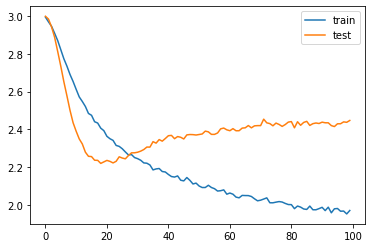

In [31]:
# x_test = tf.stack(x_test)
# y_test = tf.stack(y_test)

# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=1)
_, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred=model.predict(x_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)

print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))


6/6 [==============================] - 1s 17ms/step
[[4 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0]
 [0 3 0 0 0 1 2 0 0 0 0 0 0 0 1 1 0 0 1 0]
 [0 2 3 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1]
 [3 0 0 0 1 0 0 1 1 1 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 2 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 4 0 0 0 0 0 0 0 0 2 0 1 1 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 1 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 6 0 0 0 1 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 1 1 0 2 1 0 0 0 0 2 0 0 0 0]
 [0 0 1 0 3 2 0 0 0 0 1 0 0 0 0 0 0 1 1 0]
 [0 0 0 2 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 2 0 0 0 0 1 2 2]
 [1 0 0 0 2 0 0 0 0 1 0 0 1 2 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 8 0 0 0 0 0]
 [0 0 1 0 1 3 0 0 0 1 0 0 0 1 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 6 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 1 2 2 0 0 2 0 0]
 [0 0 3 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 3 1]
 [0 1 0 0 1 0 0 0 1 0 0 0 2 0 0 0 0 2 1 1]]
              precision    recall  f1-score   support

           0       0.50      0.5